## Step 1: Validate the files

This data set is provided by Kaggle as part of the `Titanic: Machine Learning from Disaster!` challenge.
I have already downloaded the data, and it can be found in the `./kaggle/input/titanic` dir associated with this notebook.

In [175]:
import os

data_dir = "kaggle/input/titanic/"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [176]:
[f"{kaggle_input_dir}{file}" for file in os.listdir(kaggle_input_dir)]

['kaggle/input/titanic/gender_submission.csv',
 'kaggle/input/titanic/train.csv',
 'kaggle/input/titanic/test.csv']

## Step 2: Explore the data

Let's first import some of the packages we'll need, then we can explore our data sets.

In [177]:
import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn.model_selection

In [178]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [179]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [180]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


We can already see that the data is organized very well, and there are some obvious features we can work with, such as `Age`, `Sex`, and `Pclass` (ticket class), `sibsp` (# of siblings / spouses aboard the Titanic), and `parch` (# of parents / children aboard the Titanic).

Other features like `Name`, might prove to be less important.

We also see our `Classifier` labeled here as `Survived`. This is obviously missing from the test set.

We can aso engineer some new features from this data, for instance; We can create a `child` feature based on age, as well as an `senior` feature.

## Step 3: Visualize the data

Since we have some theories about the data, we can visualize the data to get a better idea of which features are really correlated to survival. Let's start with `Pclass`

In [181]:
pclass_np = train[["Survived", "Pclass"]].values
survivors_pclass = pclass_np[pclass_np[:,0] == 1,:][:,1]
non_survivors_pclass = pclass_np[pclass_np[:,0] == 0,:][:,1]
print(non_survivors_pclass[:10])

[3 3 3 1 3 3 3 3 3 3]


(array([136.,  87., 119.]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)

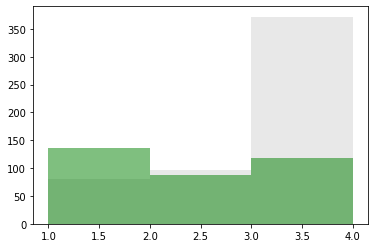

In [182]:
pclass_bins = range(1, 5)
plt.hist(non_survivors_pclass, bins=pclass_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_pclass, bins=pclass_bins, color="green", alpha=0.5)

We can see that our hunch was correct regarding `Pclass`, 3rd class passengers are much more likely not to survive, while 1st class passengers are the most likely to survive.

Let's look at `Age`, `Sex`, `SibSp`, and `Parch` next.

In [183]:
age_np = train[["Survived", "Age"]].values
survivors_age = age_np[age_np[:,0] == 1,:][:,1]
non_survivors_age = age_np[age_np[:,0] == 0,:][:,1]
# remove NaN
survivors_age = survivors_age[~np.isnan(survivors_age)]
non_survivors_age = non_survivors_age[~np.isnan(non_survivors_age)]
print(non_survivors_age[:10])

[22. 35. 54.  2. 20. 39. 14.  2. 31. 35.]


(array([20.,  9.,  4., 15., 27., 36., 30., 36., 34., 17., 12., 12., 14.,
         7.,  5.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
        69, 73, 77, 81, 85, 89, 93, 97]),
 <a list of 24 Patch objects>)

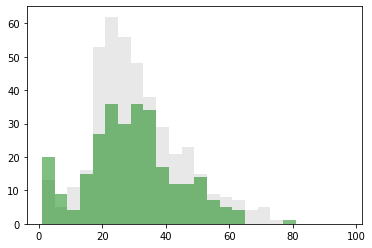

In [184]:
age_bins = range(1, 100, 4)
plt.hist(non_survivors_age, bins=age_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_age, bins=age_bins, color="green", alpha=0.5)

Again we find something interesting, while most age groups have proportional mortality rates to number of passengers, young children have significantly *higher* survival rates, while certain older groups have significantly *higher* mortality rates. So `Senior` and `Child` might prove to be good features to engineer.

In [185]:
sex_np = train[["Survived", "Sex"]].values
survivors_sex = sex_np[sex_np[:,0] == 1,:][:,1]
non_survivors_sex = sex_np[sex_np[:,0] == 0,:][:,1]
print(non_survivors_sex[:10])

['male' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'female']


(array([109.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 233.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

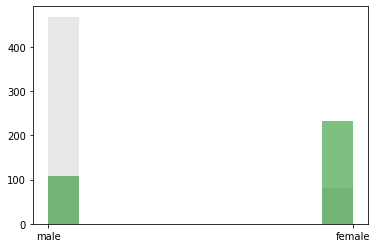

In [186]:
plt.hist(non_survivors_sex, color="lightgrey", alpha=0.5)
plt.hist(survivors_sex, color="green", alpha=0.5)

Again we see a trend, males are likely to not survive, while females are likely to survive.

In [187]:
sibsp_np = train[["Survived", "SibSp"]].values
survivors_sibsp = sibsp_np[sibsp_np[:,0] == 1,:][:,1]
non_survivors_sibsp = sibsp_np[sibsp_np[:,0] == 0,:][:,1]
print(non_survivors_sibsp[:10])

[1 0 0 0 3 0 1 0 4 1]


(array([112.,  13.,   4.,   3.,   0.,   0.,   0.,   0.]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

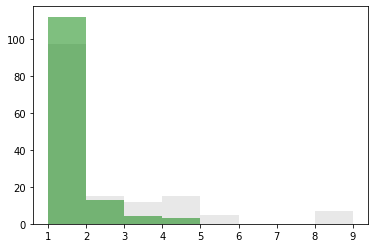

In [188]:
sibsp_bins = range(1, 10)
plt.hist(non_survivors_sibsp, bins=sibsp_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_sibsp, bins=sibsp_bins, color="green", alpha=0.5)

We find a similar story for `SibSp`, a higher `SibSp` indicates a higher mortality rate.

In [189]:
parch_np = train[["Survived", "Parch"]].values
survivors_parch = parch_np[parch_np[:,0] == 1,:][:,1]
non_survivors_parch = parch_np[parch_np[:,0] == 0,:][:,1]
print(non_survivors_parch[:10])

[0 0 0 0 1 0 5 0 1 0]


(array([65., 40.,  3.,  0.,  1.,  0.]),
 array([1, 2, 3, 4, 5, 6, 7]),
 <a list of 6 Patch objects>)

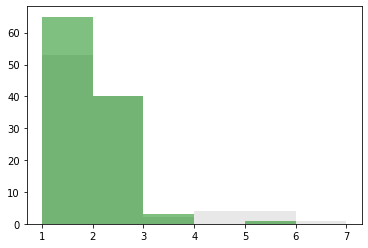

In [190]:
parch_bins = range(1, 8)
plt.hist(non_survivors_parch, bins=parch_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_parch, bins=parch_bins, color="green", alpha=0.5)

While less significant than the previous relations, we do see a relationship between high `Parch` and mortality.